In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
sst_normed = np.load('../CESM_data/CESM_SST_normalized_lat_weighted.npy').astype(np.float32)
sss_normed = np.load('../CESM_data/CESM_SSS_normalized_lat_weighted.npy').astype(np.float32)

In [3]:
lead = 12

tstep = 1032
max_epochs = 10
batch_size = 32
channels = 2

In [4]:
y = np.mean(sst_normed[:,lead:,:,:],axis=(2,3)).reshape((tstep-lead)*42,1)  
X = np.transpose(
    np.array([sst_normed,sss_normed])[:,:,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*42,33,89),
    (1,0,2,3))

In [5]:
percent_train = 0.8

X_train = torch.from_numpy( X[0:int(np.floor(percent_train*(tstep-lead)*42)),:,:,:] )
y_train = torch.from_numpy( y[0:int(np.floor(percent_train*(tstep-lead)*42)),:] )

X_val = torch.from_numpy( X[int(np.floor(percent_train*(tstep-lead)*42)):,:,:,:] )
y_val = torch.from_numpy( y[int(np.floor(percent_train*(tstep-lead)*42)):,:] )

torch.Size([34272, 2, 33, 89])

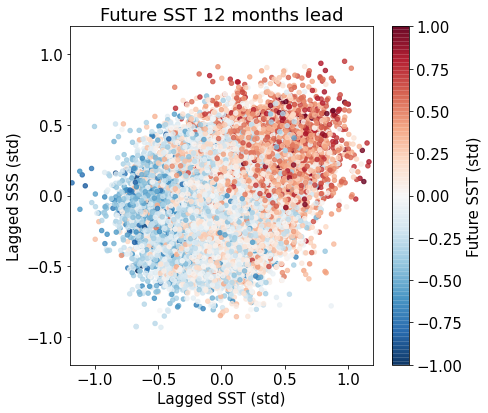

In [15]:
plt.figure(figsize=(7,6))
plt.rcParams.update({'font.size': 15})

sc = plt.scatter(np.mean(X[:,0,:,:],axis=(1,2)),
                 np.mean(X[:,1,:,:],axis=(1,2)),
                 c=y,vmin=-1,vmax=1,cmap='RdBu_r',s=20,alpha=0.8)

plt.colorbar(sc,label='Future SST (std)')
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.xlabel('Lagged SST (std)')
plt.ylabel('Lagged SSS (std)')
plt.title('Future SST '+str(lead)+' months lead')
plt.tight_layout()
#plt.savefig('colored_scatter_data.pdf')
plt.show()

In [7]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle = True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle = True)

In [8]:
model = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=(2,3)),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(2,3)),
                      
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(2,3)),            
                      
          nn.Flatten(),
          nn.Linear(in_features=7*9*64,out_features=64),
          nn.ReLU(),
          #nn.Linear(in_features=128,out_features=64),
          #nn.ReLU(),
          
          nn.Dropout(p=0.5),
          nn.Linear(in_features=64,out_features=1))

opt = torch.optim.Adam(model.parameters())
#opt = torch.optim.Adadelta(model.parameters())
loss_fn = nn.MSELoss()

In [9]:
epo_train_losses = [loss_fn(model(X_train),y_train)]
epo_val_losses = [loss_fn(model(X_val),y_val)]

for iepoch in tqdm(range(max_epochs)):
    
    batch_train_losses = []
    model.train()
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.squeeze(), y_batch.squeeze())
        batch_train_losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
    epo_train_losses.append( sum(batch_train_losses)/len(batch_train_losses) )

    batch_val_losses = []
    with torch.set_grad_enabled(False):
        for x_batch_val, y_batch_val in val_loader:
            y_pred = model(x_batch_val)
            loss = loss_fn(y_pred.squeeze(), y_batch_val.squeeze())
            batch_val_losses.append(loss.item())
        epo_val_losses.append( sum(batch_val_losses)/len(batch_val_losses) )

100%|██████████| 10/10 [11:18<00:00, 67.85s/it]


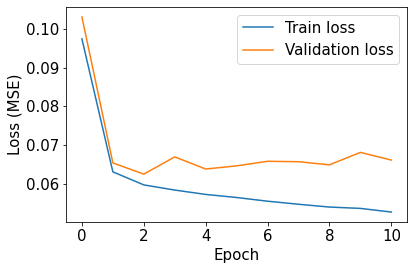

In [14]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 15})

plt.plot(epo_train_losses)
plt.plot(epo_val_losses)
plt.legend(['Train loss','Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.tight_layout()

#plt.savefig('loss_at_epoch.pdf')
plt.show()

In [11]:
model.eval()

y_pred_val = model(X_val).detach().numpy()
y_val = y_val.detach().numpy()

y_pred_train = model(X_train).detach().numpy()
y_train = y_train.detach().numpy()

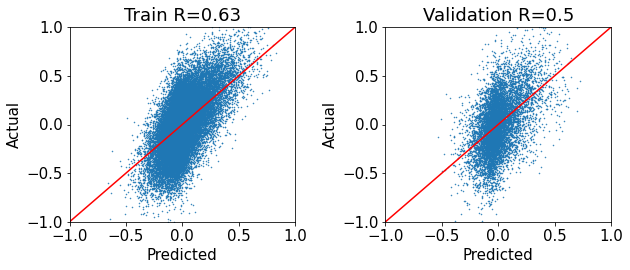

In [57]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'font.size': 15})

plt.subplot(121)
plt.plot( y_pred_train,y_train,'.',markersize=1 )
plt.plot( [-1,1],[-1,1] ,'r-')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Train R='+ str(round(np.corrcoef( y_pred_train.T[0,:], y_train.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(122)
plt.plot( y_pred_val,y_val,'.', markersize=1)
plt.plot( [-1,1],[-1,1] ,'r-')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Validation R='+ str(round( np.corrcoef( y_pred_val.T[0,:], y_val.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

#plt.savefig('train_validation_correlation.pdf')

plt.show()

In [59]:
# calculate linear regression model
lr_X = np.mean( X_train.detach().numpy(),axis=(2,3) ).T
lr_Y = y_train.T
theta = np.linalg.inv( lr_X@lr_X.T ) @ lr_X @ lr_Y.T

lr_X_val = np.mean( X_val.detach().numpy(), axis=(2,3) ).T
lr_Y_val = lr_X_val[0,:]*theta[0] + lr_X_val[1,:]*theta[1]
lr_Y_train = lr_X[0,:]*theta[0] + lr_X[1,:]*theta[1]

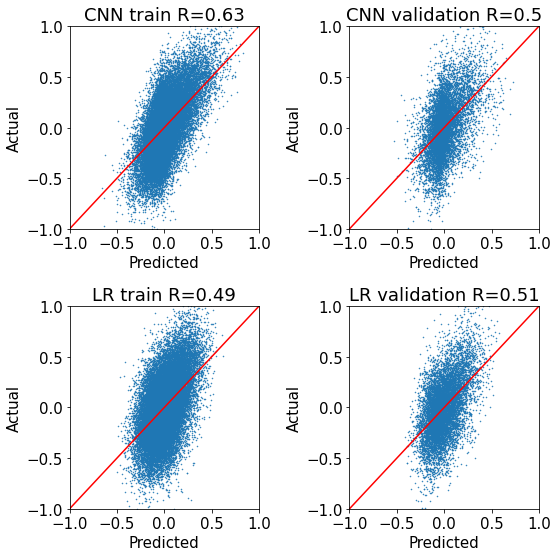

In [71]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 15})

plt.subplot(221)
plt.plot( y_pred_train,y_train,'.',markersize=1 )
plt.plot( [-1,1],[-1,1] ,'r-')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('CNN train R='+ str(round(np.corrcoef( y_pred_train.T[0,:], y_train.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(222)
plt.plot( y_pred_val,y_val,'.', markersize=1)
plt.plot( [-1,1],[-1,1] ,'r-')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('CNN validation R='+ str(round( np.corrcoef( y_pred_val.T[0,:], y_val.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(223)
plt.plot( lr_Y_train, lr_Y[0,:], '.', markersize=1 )
plt.plot( [-1,1],[-1,1] ,'r-')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('LR train R='+ str(round( np.corrcoef( lr_Y_train, lr_Y )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(224)
plt.plot( lr_Y_val, y_val, '.', markersize=1 )
plt.plot( [-1,1],[-1,1] ,'r-')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('LR validation R='+ str(round( np.corrcoef( lr_Y_val, y_val.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

#plt.savefig('train_validation_correlation_with_linear_reg.pdf')

plt.show()